In [1]:
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)
import src.MPC_Casadi as mpc
import src.car_plotting as cplot
import src.TrafficWorld as tw
np.set_printoptions(precision=2)
import src.IterativeBestResponseMPCMultiple as mibr


SAVE = False
PLOT = True
rounds_ibr = 225
n_other_cars = 4
N = 50
###### LATEX Dimensions (Not currently Working)

fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
fig_size = [6, 4]
#################33

In [23]:
subdir_name_prosocial = "20200228_114916random_pro"    
folder_prosocial = "results/" + subdir_name_prosocial + "/"

subdir_name_ego = "20200228_114851random_altru"    
folder_ego = "results/" + subdir_name_ego + "/"

subdir_name_altruistic = "20200228_114851random_altru"    
folder_altruistic = "results/" + subdir_name_altruistic + "/"
################ Analyze Results

In [25]:
import pickle
mpc = pickle.load(open(folder_prosocial+"data/"+"mpc3.p",'rb'))
print(mpc.theta_iamb)

mpc = pickle.load(open(folder_ego+"data/"+"mpc3.p",'rb'))
print(mpc.theta_iamb)

mpc = pickle.load(open(folder_altruistic+"data/"+"mpc3.p",'rb'))
print(mpc.theta_iamb)

0.7853981633974483
0.08726646259971647
0.08726646259971647


Amb X     Final   Avg.  Min.   Max.  
Egoistic  & 132.28 & 132.08 & 131.61 & 133.82
Prosocial  & 132.92 & 132.81 & 131.94 & 133.82
Altruistic  & 132.98 & 133.13 & 132.94 & 133.82
Veh 1     Final   Avg.  Min.   Max.  
 
Egoistic  & 109.54 & 109.20 & 99.54 & 111.44
Prosocial  & 109.43 & 109.29 & 94.44 & 111.72
Altruistic  & 107.84 & 107.27 & 96.86 & 111.26


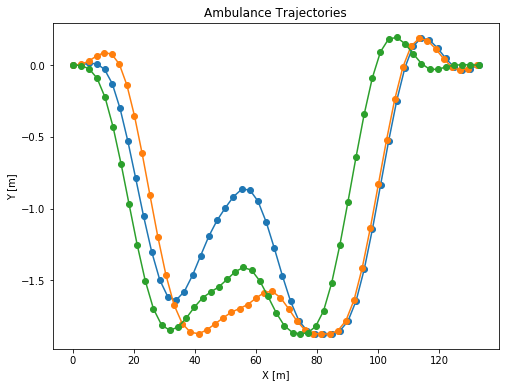

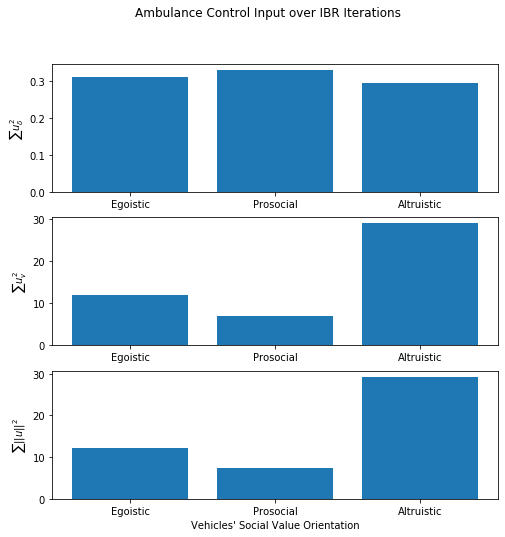

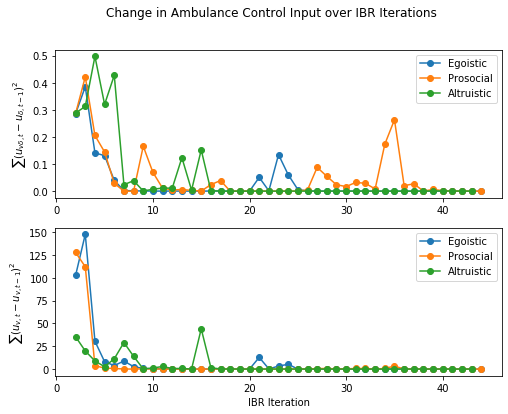

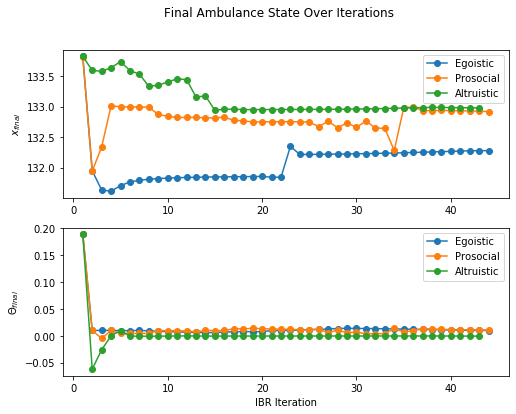

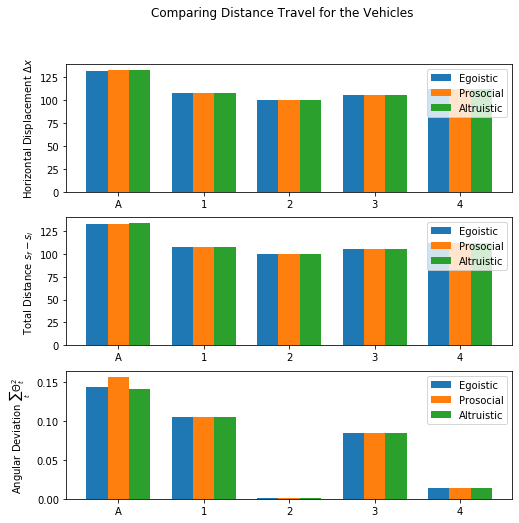

In [2]:
for sim_i in range(3):
    if sim_i==0:
        folder = folder_prosocial
    elif sim_i==1:
        folder = folder_ego
    else:
        folder = folder_altruistic


    n_full_rounds = 0  # rounods that the ambulance planned 
    n_all_rounds = 0

    all_xamb = np.zeros((6, N+1, rounds_ibr))
    all_uamb = np.zeros((2, N, rounds_ibr))
    all_xcost = np.zeros((3, rounds_ibr))

    mpc = pickle.load(open(folder+"data/"+"mpc3.p"))
    all_other_x = [np.zeros((6, N+1, rounds_ibr)) for i in range(n_other_cars)]
    all_other_u = [np.zeros((2, N, rounds_ibr)) for i in range(n_other_cars)]
    all_other_cost = [np.zeros((3, rounds_ibr)) for i in range(n_other_cars)]
    for amb_ibr_i in range(rounds_ibr):
        if (amb_ibr_i % (n_other_cars + 1) == 1) and amb_ibr_i>1:
            ibr_prefix =  '%03d'%amb_ibr_i
            try:
                xamb, uamb, xamb_des, xothers, uothers, xothers_des = mibr.load_state(folder + "data/" + ibr_prefix, n_other_cars)
                all_xamb[:,:,n_full_rounds] = xamb
                all_uamb[:,:,n_full_rounds] = uamb

                for i in range(n_other_cars):
                    all_other_x[i][:,:,n_full_rounds] = xothers[i] 
                    all_other_u[i][:,:,n_full_rounds] = uothers[i]
                n_full_rounds += 1
            except FileNotFoundError:
                # print("amb_ibr_i %d missing"%amb_ibr_i)
                pass
            n_all_rounds += 1

    ### Clip the extra dimension
    all_xamb = all_xamb[:,:,:n_full_rounds]
    all_uamb = all_uamb[:,:,:n_full_rounds]
    for i in range(n_other_cars):
        all_other_x[i] = all_other_x[i][:,:,:n_full_rounds]
        all_other_u[i] = all_other_u[i][:,:,:n_full_rounds]
    ibr_brounds_array = np.array(range(1, n_full_rounds +1))


    if sim_i==0: #prosocial directory
        all_xamb_pro = all_xamb
        all_uamb_pro = all_uamb
        all_other_x_pro = all_other_x
        all_other_u_pro = all_other_u
        ibr_brounds_array_pro = ibr_brounds_array  
    elif sim_i==1: #egoistic directory
        all_xamb_ego = all_xamb
        all_uamb_ego = all_uamb
        all_other_x_ego = all_other_x
        all_other_u_ego = all_other_u
        ibr_brounds_array_ego = ibr_brounds_array  
    else: #altruistic directory
        all_xamb_altru = all_xamb
        all_uamb_altru = all_uamb
        all_other_x_altru = all_other_x
        all_other_u_altru = all_other_u
        ibr_brounds_array_altru = ibr_brounds_array          



### SAVING IN PROSOCIAL'S DIRECTORy
folder = folder_prosocial

fig_trajectory, ax_trajectory = plt.subplots(1,1)
ax_trajectory.set_title("Ambulance Trajectories")
# fig_trajectory.set_figheight(fig_height)
# fig_trajectory.set_figwidth(fig_width)
fig_trajectory.set_size_inches((8,6))
ax_trajectory.plot(all_xamb_pro[0,:,-1], all_xamb_pro[1,:,-1], '-o', label="Prosocial")
ax_trajectory.plot(all_xamb_ego[0,:,-1], all_xamb_ego[1,:,-1], '-o', label="Egoistic")
ax_trajectory.plot(all_xamb_altru[0,:,-1], all_xamb_altru[1,:,-1], '-o', label="Altruistic")

ax_trajectory.set_xlabel("X [m]")
ax_trajectory.set_ylabel("Y [m]")
if SAVE:
    fig_file_name = folder + 'plots/' + 'cfig1_amb_trajectory.eps'
    fig_trajectory.savefig(fig_file_name, dpi=95, format='eps')
    print("Save to....", fig_file_name)

##########################################333333

svo_labels = ["Egoistic", "Prosocial", "Altruistic"]

fig_uamb, ax_uamb = plt.subplots(3,1)
fig_uamb.set_size_inches((8,8))
fig_uamb.suptitle("Ambulance Control Input over IBR Iterations")
# ax_uamb[0].plot(ibr_brounds_array, np.sum(all_uamb[0,:,:] * all_uamb[0,:,:], axis=0), '-o')
ax_uamb[0].bar(range(3), [
                np.sum(all_uamb_ego[0,:,-1] * all_uamb_ego[0,:,-1],axis=0),
                np.sum(all_uamb_pro[0,:,-1] * all_uamb_pro[0,:,-1], axis=0),                
                np.sum(all_uamb_altru[0,:,-1] * all_uamb_altru[0,:,-1],axis=0)],)
# ax_uamb[0].set_xlabel("IBR Iteration")
ax_uamb[0].set_ylabel("$\sum u_{\delta}^2$")
ax_uamb[0].set_xticks(range(3))
ax_uamb[0].set_xticklabels(svo_labels)    

ax_uamb[1].bar(range(3), [
                        np.sum(all_uamb_ego[1,:,-1] * all_uamb_ego[1,:,-1],axis=0),
                        np.sum(all_uamb_pro[1,:,-1] * all_uamb_pro[1,:,-1], axis=0),
                        np.sum(all_uamb_altru[1,:,-1] * all_uamb_altru[1,:,-1],axis=0)],)
# ax_uamb[1].set_xlabel("IBR Iteration")
ax_uamb[1].set_ylabel("$\sum u_{v}^2$")
ax_uamb[1].set_xticks(range(3))
ax_uamb[1].set_xticklabels(svo_labels)    

ax_uamb[2].bar(range(3), [
                np.sum(all_uamb_ego[0,:,-1] * all_uamb_ego[0,:,-1],axis=0) + np.sum(all_uamb_ego[1,:,-1] * all_uamb_ego[1,:,-1],axis=0),
                np.sum(all_uamb_pro[0,:,-1] * all_uamb_pro[1,:,-1], axis=0) + np.sum(all_uamb_pro[1,:,-1] * all_uamb_pro[1,:,-1], axis=0),
                np.sum(all_uamb_altru[0,:,-1] * all_uamb_altru[0,:,-1],axis=0) + np.sum(all_uamb_altru[1,:,-1] * all_uamb_altru[1,:,-1],axis=0)],)
ax_uamb[2].set_xlabel("Vehicles' Social Value Orientation")
ax_uamb[2].set_ylabel("$\sum ||u||^2$")   

ax_uamb[2].set_xticks(range(3))
ax_uamb[2].set_xticklabels(svo_labels)
if SAVE:
    fig_file_name = folder + 'plots/' + 'cfig2_amb_ctrl_iterations.eps'
    fig_uamb.savefig(fig_file_name, dpi=95, format='eps')
    print("Save to....", fig_file_name)
    

##########################################################
#### Convergence
#########################################################
fig_reluamb, ax_reluamb = plt.subplots(2,1)
# fig_reluamb.set_figheight(fig_height)
# fig_reluamb.set_figwidth(fig_width)
fig_reluamb.set_size_inches((8,6))
for sim_i in range(3):
    if sim_i==0: #prosocial directory
        all_uamb = all_uamb_ego
        label = "Egoistic"
        ibr_brounds_array = ibr_brounds_array_ego        
    elif sim_i==1: #egoistic directory
        all_uamb = all_uamb_pro 
        label = "Prosocial"
        ibr_brounds_array = ibr_brounds_array_pro 
    else: #altruistic directory
        all_uamb = all_uamb_altru
        all_other_u = all_other_u_altru
        label = "Altruistic"
        ibr_brounds_array = ibr_brounds_array_altru       
    ax_reluamb[0].plot(ibr_brounds_array[1:], np.sum((all_uamb[0,:,1:]-all_uamb[0,:,0:-1])*(all_uamb[0,:,1:]-all_uamb[0,:,0:-1]), axis=0), '-o', label=label)
    ax_reluamb[1].plot(ibr_brounds_array[1:], np.sum((all_uamb[1,:,1:]-all_uamb[1,:,0:-1])*(all_uamb[1,:,1:]-all_uamb[1,:,0:-1]), axis=0), '-o', label=label)

ax_reluamb[0].set_ylabel("$\sum (u_{v\delta,t}-u_{\delta,t-1})^2$")
ax_reluamb[1].set_xlabel("IBR Iteration")
ax_reluamb[1].set_ylabel("$\sum (u_{v,t}-u_{v,t-1})^2$")
ax_reluamb[0].legend()
ax_reluamb[1].legend()
fig_reluamb.suptitle("Change in Ambulance Control Input over IBR Iterations")

if SAVE:
    fig_file_name = folder + 'plots/' + 'cfig3_change_amb_ctrl_iterations.eps'
    fig_reluamb.savefig(fig_file_name, dpi=95, format='eps')
    print("Save to....", fig_file_name)

###################################################################3
##################################################################
fig_xfinal, ax_xfinal = plt.subplots(2,1)
fig_xfinal.suptitle("Final Ambulance State Over Iterations")
fig_xfinal.set_size_inches((8,6))
# fig_xfinal.set_figheight(fig_height)
# fig_xfinal.set_figwidth(fig_width)

for sim_i in range(3):
    if sim_i==0: #prosocial directory
        all_uamb = all_uamb_ego
        all_xamb = all_xamb_ego
        label = "Egoistic"
        ibr_brounds_array = ibr_brounds_array_ego        
    elif sim_i==1: #egoistic directory
        all_uamb = all_uamb_pro 
        all_xamb = all_xamb_pro
        label = "Prosocial"
        ibr_brounds_array = ibr_brounds_array_pro 
    else: #altruistic directory
        all_uamb = all_uamb_altru
        all_xamb = all_xamb_altru
        all_other_u = all_other_u_altru
        label = "Altruistic"        
        ibr_brounds_array = ibr_brounds_array_altru  
    
    ax_xfinal[0].plot(ibr_brounds_array, all_xamb[0,-1,:], '-o', label=label)
    ax_xfinal[1].plot(ibr_brounds_array, all_xamb[2,-1,:], '-o', label=label)

# ax_reluamb[0].set_xlabel("IBR Iteration")

ax_xfinal[0].set_ylabel("$x_{final}$")
ax_xfinal[0].legend()
ax_xfinal[1].set_xlabel("IBR Iteration")
ax_xfinal[1].set_ylabel(r"$\Theta_{final}$")
ax_xfinal[1].legend()
if SAVE:
    fig_file_name = folder + 'plots/' + 'cfig4_iterations_ambperformance.eps'
    fig_xfinal.savefig(fig_file_name, dpi=95, format='eps')
    print("Save to....", fig_file_name)

################################################################################
###################### NOW PLOTTING THE OTHER VEHICLES #########################

fig_xfinal_all, ax_xfinal_all = plt.subplots(3,1)
fig_xfinal_all.suptitle("Comparing Distance Travel for the Vehicles")
fig_xfinal_all.set_size_inches((8,8))
# fig_xfinal_all.set_figheight(fig_height)
# fig_xfinal_all.set_figwidth(fig_width)

for sim_i in range(3):
    if sim_i==0: #prosocial directory
        all_uamb = all_uamb_ego
        all_xamb = all_xamb_ego
        label = "Egoistic"
        ibr_brounds_array = ibr_brounds_array_ego        
    elif sim_i==1: #egoistic directory
        all_uamb = all_uamb_pro 
        all_xamb = all_xamb_pro
        label = "Prosocial"
        ibr_brounds_array = ibr_brounds_array_pro         
    else: #altruistic directory
        all_uamb = all_uamb_altru
        all_xamb = all_xamb_altru
        all_other_u = all_other_u_altru
        label = "Altruistic"        
        ibr_brounds_array = ibr_brounds_array_altru  
    bar_width = 0.5
    inter_car_width = 2*bar_width

    width_offset = bar_width*sim_i
    
    ticks = [width_offset + (2*bar_width + inter_car_width)*c for c in range(n_other_cars + 1)]
    ax_xfinal_all[0].bar(ticks, 
    [all_xamb[0, -1, -1] - all_xamb[0, 0, -1]] + [all_other_x[i][0,-1,-1] - all_other_x[i][0,0,-1] for i in range(n_other_cars)],
    bar_width, label=label)
    # ax_xfinal_all[0].set_xticks(range(n_other_cars + 1))
    # ax_xfinal_all[0].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

    ax_xfinal_all[1].bar(ticks,  
    [all_xamb[-1, -1, -1] - all_xamb[-1, 0, -1]] + [all_other_x[i][-1,-1,-1] - all_other_x[i][-1,0,-1] for i in range(n_other_cars)],
    bar_width, label=label)
    # ax_xfinal_all[1].set_xticks(range(n_other_cars + 1))
    # ax_xfinal_all[1].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

    ax_xfinal_all[2].bar(ticks,  
    [np.sum(all_xamb[2,:,-1]*all_xamb[2,:,-1])] +  [np.sum(all_other_x[i][2,:,-1]*all_other_x[i][2,:,-1]) for i in range(n_other_cars)],
    bar_width, label=label)

width_offset = bar_width*1
ticks = [width_offset + (2*bar_width + inter_car_width)*c for c in range(n_other_cars + 1)]

ax_xfinal_all[2].legend()
ax_xfinal_all[2].set_xticks(ticks)
ax_xfinal_all[2].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

ax_xfinal_all[0].set_ylabel("Horizontal Displacement $\Delta x$")
ax_xfinal_all[0].legend()
ax_xfinal_all[0].set_xticks(ticks)
ax_xfinal_all[0].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

ax_xfinal_all[1].set_ylabel("Total Distance $s_f - s_i$")
ax_xfinal_all[1].legend()
ax_xfinal_all[1].set_xticks(ticks)
ax_xfinal_all[1].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

ax_xfinal_all[2].set_ylabel("Angular Deviation $\sum_{t} \Theta_t^2$")

if SAVE:
    fig_file_name = folder + 'plots/' + 'cfig5_vehicles_comparison.eps'
    fig_xfinal_all.savefig(fig_file_name, dpi=95, format='eps')
    print("Save to....", fig_file_name)


#########################Let's Reproduce the Table ####################33
print("Amb X     Final   Avg.  Min.   Max.  ")
print("Egoistic  & %.02f & %.02f & %.02f & %.02f"%(t_final_ego[-1], np.mean(t_final_ego), np.min(t_final_ego), np.max(t_final_ego)))
print("Prosocial  & %.02f & %.02f & %.02f & %.02f"%(t_final_pro[-1], np.mean(t_final_pro), np.min(t_final_pro), np.max(t_final_pro)))
print("Altruistic  & %.02f & %.02f & %.02f & %.02f"%(t_final_altru[-1], np.mean(t_final_altru), np.min(t_final_altru), np.max(t_final_altru)))

print("Veh 1     Final   Avg.  Min.   Max.  ")
i = 0
veh_displace_ego = all_other_x_ego[i][0,-1,:] - all_other_x_ego[i][0,0,:]
veh_displace_pro = all_other_x_pro[i][0,-1,:] - all_other_x_pro[i][0,0,:]
veh_displace_altru = all_other_x_altru[i][0,-1,:] - all_other_x_altru[i][0,0,:]

print(" ")
print("Egoistic  & %.02f & %.02f & %.02f & %.02f"%(veh_displace_ego[-1], np.mean(veh_displace_ego), np.min(veh_displace_ego), np.max(veh_displace_ego)))
print("Prosocial  & %.02f & %.02f & %.02f & %.02f"%(veh_displace_pro[-1], np.mean(veh_displace_pro), np.min(veh_displace_pro), np.max(veh_displace_pro)))
print("Altruistic  & %.02f & %.02f & %.02f & %.02f"%(veh_displace_altru[-1], np.mean(veh_displace_altru), np.min(veh_displace_altru), np.max(veh_displace_altru)))


if PLOT:
    plt.show()


In [22]:
np.pi/2

1.5707963267948966

In [3]:
all_xamb = all_xamb_ego
t_final_ego = []

for it in range(all_xamb.shape[2]):
    current_x_state = all_xamb[:,:,it]
    current_x = all_xamb[0,:,it]
    goal_x = 130
    dt = 0.2
    # dt = x_mpc.dt
    i_upper = np.searchsorted(current_x, goal_x)
    i_lower = i_upper - 1

    t_lower = dt*i_lower
    x_lower = current_x[i_lower]
    v_x_lower = np.cos(current_x_state[2, i_lower]) * current_x_state[4, i_lower]
#         print("%.03f %.03f %.03f"%(x_lower, v_x_lower, t_lower))
    distance_travel_from_lower = goal_x - x_lower
    approx_extra_time_to_goal = distance_travel_from_lower/v_x_lower
    finish_time = t_lower + approx_extra_time_to_goal    
    t_final_ego += [finish_time]

all_xamb = all_xamb_pro
t_final_pro = []
for it in range(all_xamb.shape[2]):
    current_x_state = all_xamb[:,:,it]
    current_x = all_xamb[0,:,it]
    goal_x = 130
    dt = 0.2
    # dt = x_mpc.dt
    i_upper = np.searchsorted(current_x, goal_x)
    i_lower = i_upper - 1

    t_lower = dt*i_lower
    x_lower = current_x[i_lower]
    v_x_lower = np.cos(current_x_state[2, i_lower]) * current_x_state[4, i_lower]
#         print("%.03f %.03f %.03f"%(x_lower, v_x_lower, t_lower))
    distance_travel_from_lower = goal_x - x_lower
    approx_extra_time_to_goal = distance_travel_from_lower/v_x_lower
    finish_time = t_lower + approx_extra_time_to_goal    
    t_final_pro += [finish_time]
    
all_xamb = all_xamb_altru
t_final_altru = []
for it in range(all_xamb.shape[2]):
    current_x_state = all_xamb[:,:,it]
    current_x = all_xamb[0,:,it]
    goal_x = 130
    dt = 0.2
    # dt = x_mpc.dt
    i_upper = np.searchsorted(current_x, goal_x)
    i_lower = i_upper - 1

    t_lower = dt*i_lower
    x_lower = current_x[i_lower]
    v_x_lower = np.cos(current_x_state[2, i_lower]) * current_x_state[4, i_lower]
#         print("%.03f %.03f %.03f"%(x_lower, v_x_lower, t_lower))
    distance_travel_from_lower = goal_x - x_lower
    approx_extra_time_to_goal = distance_travel_from_lower/v_x_lower
    finish_time = t_lower + approx_extra_time_to_goal    
    t_final_altru += [finish_time]    


In [4]:


#########################Let's Reproduce the Table ####################33
print("Amb X     Final   Avg.  Min.   Max.  ")
print("Egoistic  & %.02f & %.02f & %.02f & %.02f"%(t_final_ego[-1], np.mean(t_final_ego), np.min(t_final_ego), np.max(t_final_ego)))
print("Prosocial  & %.02f & %.02f & %.02f & %.02f"%(t_final_pro[-1], np.mean(t_final_pro), np.min(t_final_pro), np.max(t_final_pro)))
print("Altruistic  & %.02f & %.02f & %.02f & %.02f"%(t_final_altru[-1], np.mean(t_final_altru), np.min(t_final_altru), np.max(t_final_altru)))

# print("Veh 1     Final   Avg.  Min.   Max.  ")
# i = 0
# veh_displace_ego = all_other_x_ego[i][0,-1,:] - all_other_x_ego[i][0,0,:]
# veh_displace_pro = all_other_x_pro[i][0,-1,:] - all_other_x_pro[i][0,0,:]
# veh_displace_altru = all_other_x_altru[i][0,-1,:] - all_other_x_altru[i][0,0,:]

# print(" ")
# print("Egoistic  & %.02f & %.02f & %.02f & %.02f"%(veh_displace_ego[-1], np.mean(veh_displace_ego), np.min(veh_displace_ego), np.max(veh_displace_ego)))
# print("Prosocial  & %.02f & %.02f & %.02f & %.02f"%(veh_displace_pro[-1], np.mean(veh_displace_pro), np.min(veh_displace_pro), np.max(veh_displace_pro)))
# print("Altruistic  & %.02f & %.02f & %.02f & %.02f"%(veh_displace_altru[-1], np.mean(veh_displace_altru), np.min(veh_displace_altru), np.max(veh_displace_altru)))


Amb X     Final   Avg.  Min.   Max.  
Egoistic  & 9.83 & 9.85 & 9.71 & 9.88
Prosocial  & 9.78 & 9.79 & 9.71 & 9.86
Altruistic  & 9.78 & 9.77 & 9.71 & 9.78


In [9]:
sav = (9.86-9.78)/9.86 * 100

In [11]:
60 * sav / 100 * 60

29.208924949290083